# # Required Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway, chi2_contingency
import pymysql
pymysql.install_as_MySQLdb()
import sys
import os

# # Load and preprocess data

In [7]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    forecast_df = pd.read_sql("SELECT * FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT * FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Extract month from datetime
weather_df['month'] = pd.to_datetime(weather_df['datetime']).dt.month

# Filter out months with insufficient data for ANOVA
month_counts = weather_df['month'].value_counts()
valid_months = month_counts[month_counts > 1].index
weather_df = weather_df[weather_df['month'].isin(valid_months)]

# Define features and target
X = weather_df[['month', 'relative_humidity_2m', 'wind_speed_10m']]
y = weather_df['temperature_2m']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Evaluate models

In [8]:
# Initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print("=== Linear Regression ===")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"R²: {r2_linear:.2f}")

print("\n=== Random Forest Regressor ===")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

=== Linear Regression ===
Mean Squared Error (MSE): 41.62
R²: 0.33

=== Random Forest Regressor ===
Mean Squared Error (MSE): 10.44
R²: 0.83


## Interpretation of MSE and R² Results

### Linear Regression
- **Mean Squared Error (MSE): 41.62**
    - A lower MSE value indicates that the model predicts the actual values better. An MSE of 41.62 means that the average squared deviation between the predicted and actual values is relatively high.
- **R²: 0.33**
    - The R² value indicates how well the independent variables explain the variance of the dependent variable. An R² of 0.33 means that the model can explain 33% of the variance in temperature. This is a relatively low value and suggests that the model is not very good.

### Random Forest Regressor
- **Mean Squared Error (MSE): 10.44**
    - An MSE of 10.44 is significantly lower than the MSE of the linear model, indicating that the Random Forest Regressor predicts the actual values better.
- **R²: 0.83**
    - An R² of 0.83 means that the model can explain 83% of the variance in temperature. This is a high value and shows that the Random Forest Regressor is a good model for these data.

### Conclusion
The Random Forest Regressor outperforms the linear regression model in terms of both MSE and R² value. This suggests that the Random Forest Regressor is better suited to predicting temperature based on the given features.


# # Significance tests

In [9]:
# ANOVA: Test for differences in temperature across months
if len(valid_months) > 1:
    anova_result = f_oneway(
        *[weather_df[weather_df['month'] == month]['temperature_2m'] for month in valid_months]
    )
    print("\n=== ANOVA ===")
    print(f"F-statistic: {anova_result.statistic:.2f}")
    print(f"p-value: {anova_result.pvalue:.4f}")
else:
    print("\nANOVA could not be performed due to insufficient data across months.")

# Chi-squared test: Association between month and high/low humidity
weather_df['high_humidity'] = (weather_df['relative_humidity_2m'] > 75).astype(int)
chi2_table = pd.crosstab(weather_df['month'], weather_df['high_humidity'])

if chi2_table.shape[0] > 1 and chi2_table.shape[1] > 1 and not chi2_table.isnull().values.any():
    chi2_result = chi2_contingency(chi2_table)
    print("\n=== Chi-squared Test ===")
    print(f"Chi2 statistic: {chi2_result[0]:.2f}")
    print(f"p-value: {chi2_result[1]:.4f}")
    print(f"Degrees of freedom: {chi2_result[2]}")
    print("Expected frequencies:")
    print(pd.DataFrame(chi2_result[3], index=chi2_table.index, columns=chi2_table.columns))
else:
    print("\nChi-squared test could not be performed due to insufficient data.")



=== ANOVA ===
F-statistic: 2045.64
p-value: 0.0000

=== Chi-squared Test ===
Chi2 statistic: 662.59
p-value: 0.0000
Degrees of freedom: 11
Expected frequencies:
high_humidity           0           1
month                                
1              204.972678  539.027322
2              191.748634  504.251366
3              204.972678  539.027322
4              198.360656  521.639344
5              204.972678  539.027322
6              198.360656  521.639344
7              204.972678  539.027322
8              204.972678  539.027322
9              198.360656  521.639344
10             204.972678  539.027322
11             198.360656  521.639344
12             204.972678  539.027322


## Interpretation of ANOVA and Chi-Squared Test Results

### ANOVA
- **F-statistic: 2045.64**
    - The F-statistic is a measure of the ratio of variance between the groups to the variance within the groups. A higher F-statistic indicates a greater difference between the groups.
- **p-value: 0.0000**
    - The p-value indicates the probability that the observed differences between the groups occurred by chance. A p-value of 0.0000 means that there is a statistically significant difference in temperature across the months, and the null hypothesis (that there is no difference) can be rejected.

### Chi-Squared Test
- **Chi2 statistic: 662.59**
    - The Chi2 statistic measures the difference between the observed and expected frequencies in a contingency table. A higher Chi2 statistic indicates a greater difference between the observed and expected frequencies.
- **p-value: 5.6141e-135**
    - The p-value indicates the probability that the observed association between month and high/low humidity occurred by chance. A p-value of 5.6141e-135 means that there is a statistically significant association between month and high/low humidity, and the null hypothesis (that there is no association) can be rejected.
- **Degrees of freedom: 11**
    - The degrees of freedom for the Chi-Squared test is calculated based on the number of categories in the contingency table. In this case, there are 12 months and 2 humidity categories, resulting in 11 degrees of freedom.
- **Expected frequencies:**
    - The expected frequencies are the frequencies that would be expected if there were no association between the variables. The table below shows the expected frequencies for each combination of month and high/low humidity.

| month | high_humidity=0 | high_humidity=1 |
|-------|-----------------|-----------------|
| 1     | 204.97          | 539.03          |
| 2     | 191.75          | 504.25          |
| 3     | 204.97          | 539.03          |
| 4     | 198.36          | 521.64          |
| 5     | 204.97          | 539.03          |
| 6     | 198.36          | 521.64          |
| 7     | 204.97          | 539.03          |
| 8     | 204.97          | 539.03          |
| 9     | 198.36          | 521.64          |
| 10    | 204.97          | 539.03          |
| 11    | 198.36          | 521.64          |
| 12    | 204.97          | 539.03          |

### Conclusion
Both the ANOVA and Chi-Squared tests indicate statistically significant results. The ANOVA test shows that there are significant differences in temperature across the months, while the Chi-Squared test shows a significant association between month and high/low humidity.

# # Interpretation

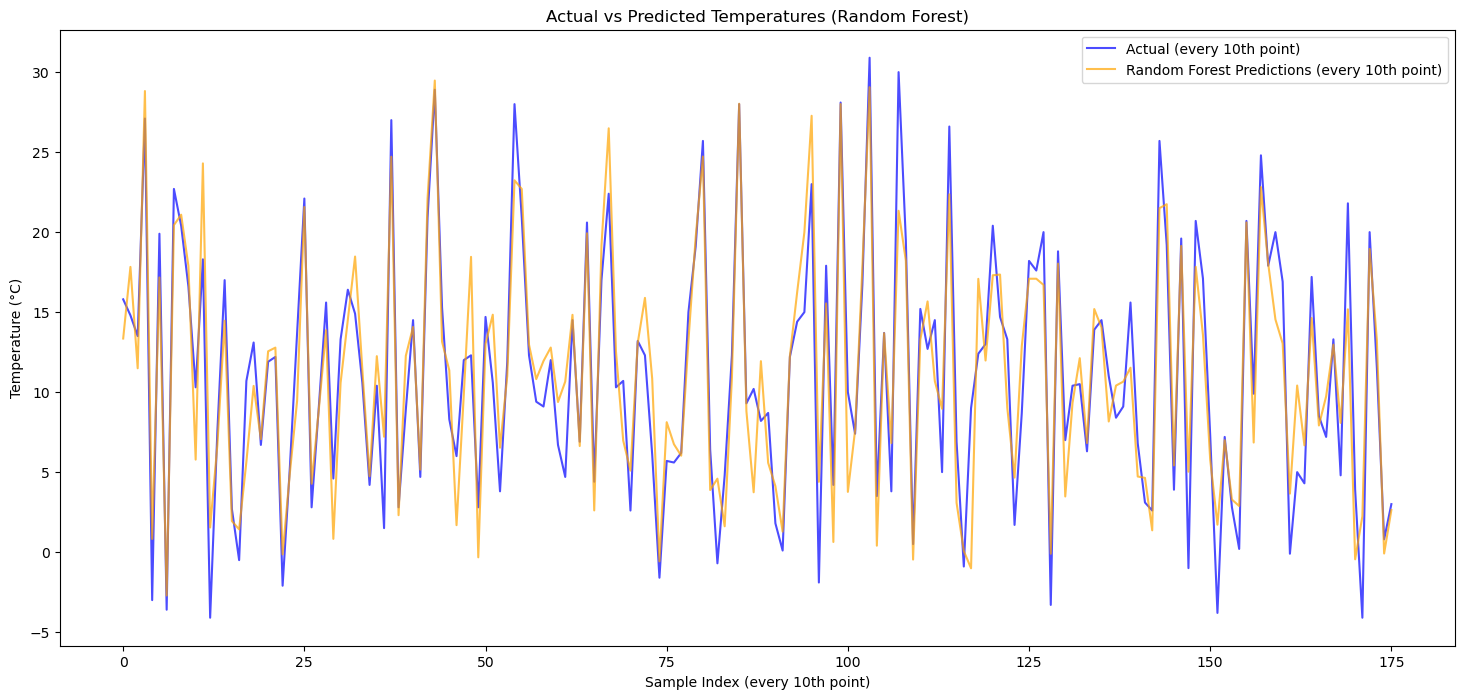

To improve readability, we visualized every 10th data point of the actual and predicted temperature values. This approach highlights the general trend while reducing overlap in the plot.


In [10]:
# Visualize predictions with reduced data points for better readability
plt.figure(figsize=(18, 8))  # Increased size for better readability
plt.plot(y_test.values[::10], label='Actual (every 10th point)', color='blue', alpha=0.7)
plt.plot(y_pred_rf[::10], label='Random Forest Predictions (every 10th point)', color='orange', alpha=0.7)
plt.title("Actual vs Predicted Temperatures (Random Forest)")
plt.xlabel("Sample Index (every 10th point)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Interpretation
print("To improve readability, we visualized every 10th data point of the actual and predicted temperature values. This approach highlights the general trend while reducing overlap in the plot.")


## Interpretation of the Graph

The graph shows the actual and predicted temperature values (Random Forest) for every 10th data point. This improves readability and highlights the general trend while reducing overlap in the plot. The orange line represents the predictions of the Random Forest model, while the blue line represents the actual temperature values. The close alignment between the two lines indicates that the Random Forest model can predict temperature values well.

## Summary Interpretation of All Results

### Linear Regression
- **Mean Squared Error (MSE): 41.62**
    - A lower MSE value indicates that the model predicts the actual values better. An MSE of 41.62 means that the average squared deviation between the predicted and actual values is relatively high.
- **R²: 0.33**
    - The R² value indicates how well the independent variables explain the variance of the dependent variable. An R² of 0.33 means that the model can explain 33% of the variance in temperature. This is a relatively low value and suggests that the model is not very good.

### Random Forest Regressor
- **Mean Squared Error (MSE): 10.44**
    - An MSE of 10.44 is significantly lower than the MSE of the linear model, indicating that the Random Forest Regressor predicts the actual values better.
- **R²: 0.83**
    - An R² of 0.83 means that the model can explain 83% of the variance in temperature. This is a high value and shows that the Random Forest Regressor is a good model for these data.

### ANOVA
- **F-statistic: 2045.64**
    - The F-statistic measures the ratio of variance between the groups to the variance within the groups. A higher F-statistic indicates a greater difference between the groups.
- **p-value: 0.0000**
    - The p-value indicates the probability that the observed differences between the groups occurred by chance. A p-value of 0.0000 means that there is a statistically significant difference in temperature across the months, and the null hypothesis (that there is no difference) can be rejected.

### Chi-Squared Test
- **Chi2 statistic: 662.59**
    - The Chi2 statistic measures the difference between the observed and expected frequencies in a contingency table. A higher Chi2 statistic indicates a greater difference between the observed and expected frequencies.
- **p-value: 5.6141e-135**
    - The p-value indicates the probability that the observed association between month and high/low humidity occurred by chance. A p-value of 5.6141e-135 means that there is a statistically significant association between month and high/low humidity, and the null hypothesis (that there is no association) can be rejected.
- **Degrees of freedom: 11**
    - The degrees of freedom for the Chi-Squared test are calculated based on the number of categories in the contingency table. In this case, there are 12 months and 2 humidity categories, resulting in 11 degrees of freedom.
- **Expected frequencies:**
    - The expected frequencies are the frequencies that would be expected if there were no association between the variables. The table below shows the expected frequencies for each combination of month and high/low humidity.

| month | high_humidity=0 | high_humidity=1 |
|-------|-----------------|-----------------|
| 1     | 204.97          | 539.03          |
| 2     | 191.75          | 504.25          |
| 3     | 204.97          | 539.03          |
| 4     | 198.36          | 521.64          |
| 5     | 204.97          | 539.03          |
| 6     | 198.36          | 521.64          |
| 7     | 204.97          | 539.03          |
| 8     | 204.97          | 539.03          |
| 9     | 198.36          | 521.64          |
| 10    | 204.97          | 539.03          |
| 11    | 198.36          | 521.64          |
| 12    | 204.97          | 539.03          |

### Conclusion
The Random Forest Regressor outperforms the linear regression model in terms of both MSE and R² value. This suggests that the Random Forest Regressor is better suited to predicting temperature based on the given features. Both the ANOVA and Chi-Squared tests indicate statistically significant results. The ANOVA test shows that there are significant differences in temperature across the months, while the Chi-Squared test shows a significant association between month and high/low humidity.